# Indigenous Trees

A look at the indigenous trees of Seattle.

## TODO

* Come up with some specific colors for the top 5 indigenous trees in the city so I can use consistent coloring between the displays.
  - The color shoud contrast well with whatever background color is used for the non-targeted trees (like the transparent gray).
* Rendering maps at an appropriate aspect ratio.

In [135]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [103]:
dftrees = pd.read_csv('data/trees_of_seattle.csv', sep='|')
# Filtering out a few trees that are way outside the city range (which causes the maps to render funny).
dftrees = dftrees[dftrees['x'] > 1245000]
dftrees = dftrees[dftrees['y'] < 275000]
with open('data/trees_of_seattle.csv.metadata.json') as fin:
    dftrees_metadata_raw = fin.read()
    dftrees_metadata = json.loads(dftrees_metadata_raw)
print('Metadata for trees_of_seattle.csv:')
print()
print(dftrees_metadata_raw)
del dftrees_metadata_raw

Metadata for trees_of_seattle.csv:

{
  "version": "0"
}



In [98]:
# Split up the trees dataset into indigenous and non-indigenous sets.
dftrees_ind = dftrees[dftrees['indigenous']]
dftrees_non = dftrees[~dftrees['indigenous']]

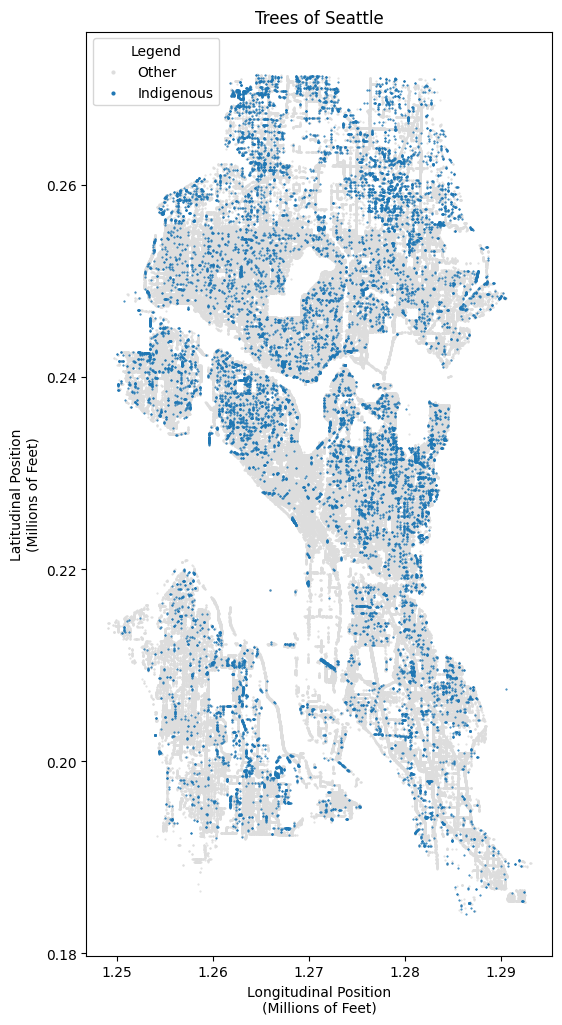

In [145]:
# Plot the location of trees in the city.
fig, ax = plt.subplots(figsize=(12, 12))  # x-dimension gets "forgotten" after set_aspect().

def scale_formatter(value, tick_number):
    return f'{value / 1_000_000.0:.2f}'

ax.xaxis.set_major_formatter(ticker.FuncFormatter(scale_formatter))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(scale_formatter))

ax.scatter(dftrees_non['x'], dftrees_non['y'], s=.25, color='#DDD', label='Other')
ax.scatter(dftrees_ind['x'], dftrees_ind['y'], s=.25, label='Indigenous')
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('Longitudinal Position\n(Millions of Feet)')
ax.set_ylabel('Latitudinal Position\n(Millions of Feet)')
ax.set_title('Trees of Seattle')
ax.legend(scatterpoints=1, markerscale=4, title='Legend')

plt.show()

<Axes: >

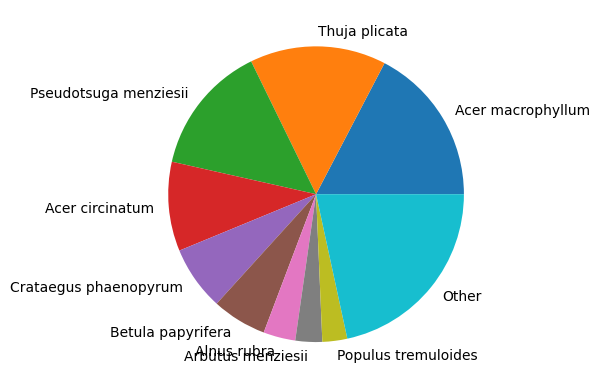

In [100]:
indigenous_counts = dftrees_ind['scientificname'].value_counts()

# The first X fraction of the trees are used as primary labels. Everything else is labeled "Other".
OTHER_CUTOFF_FRACTION = 0.80

cum_fractions = (indigenous_counts / indigenous_counts.sum()).cumsum()
before_cutoff = indigenous_counts[cum_fractions < OTHER_CUTOFF_FRACTION]
after_cutoff = indigenous_counts[cum_fractions >= OTHER_CUTOFF_FRACTION]
others = pd.Series([after_cutoff.sum()], index=['Other'])

result_counts = pd.concat([before_cutoff, others])
result_counts.plot(kind='pie')

# TODO Cleanup chart.
# TODO Add percents and counts in the labels.

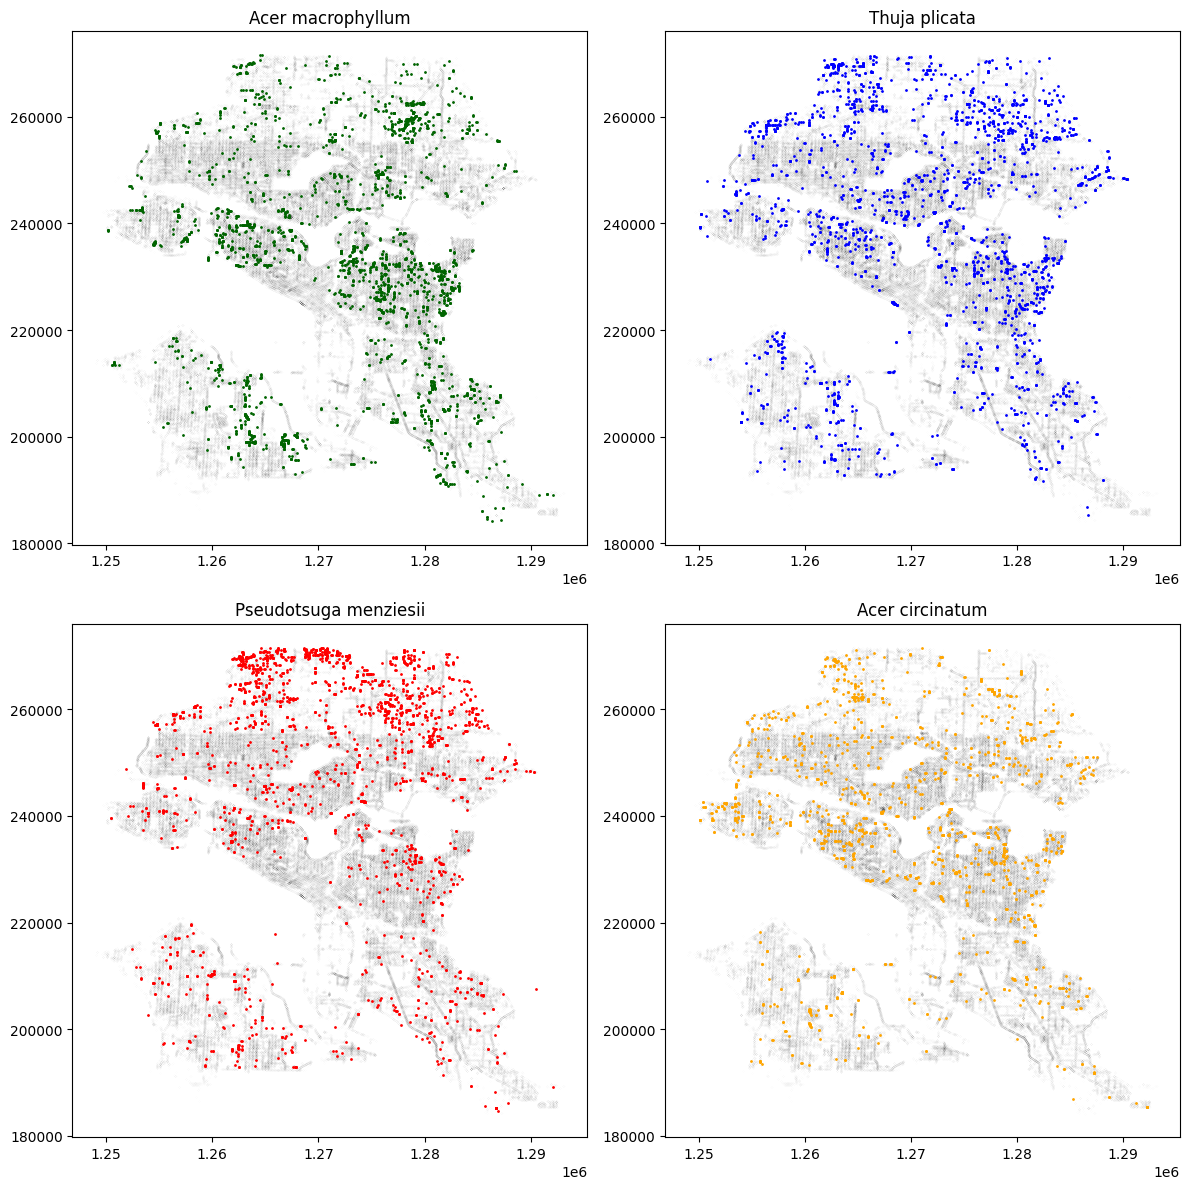

In [101]:
scientificnames = ['Acer macrophyllum', 'Thuja plicata', 'Pseudotsuga menziesii', 'Acer circinatum']
colors = ['darkgreen', 'blue', 'red', 'orange']

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    scientificname = scientificnames[i]
    color = colors[i]
    mask = dftrees['scientificname'] == scientificname
    dftrees_target = dftrees[mask]
    dftrees_other = dftrees[~mask]
    ax.scatter(dftrees_other['x'], dftrees_other['y'], s=.00003, color='black')
    ax.scatter(dftrees_target['x'], dftrees_target['y'], s=1, color=colors[i])
    ax.set_title(scientificname)

plt.tight_layout()
plt.show()
# TODO - Title
# TODO - Clean up bounds.
# TODO - Clean up labels on left and bottom.

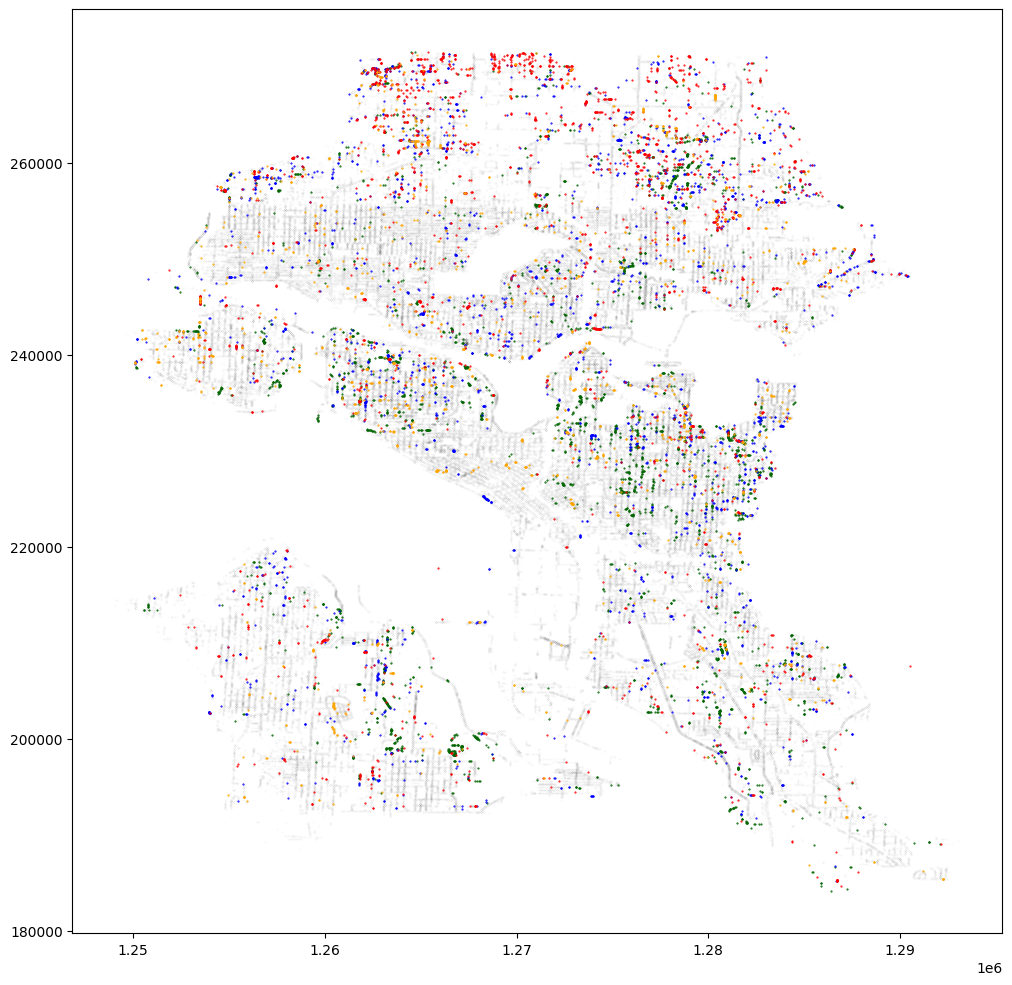

In [102]:
# Plot the location of trees in the city.
scientificnames = ['Acer macrophyllum', 'Thuja plicata', 'Pseudotsuga menziesii', 'Acer circinatum']

mask_am = dftrees['scientificname'] == 'Acer macrophyllum'
mask_tp = dftrees['scientificname'] == 'Thuja plicata'
mask_pm = dftrees['scientificname'] == 'Pseudotsuga menziesii'
mask_ac = dftrees['scientificname'] == 'Acer circinatum'
mask_other = (~mask_am) & (~mask_tp) & (~mask_pm) & (~mask_ac)

plt.figure(figsize=(12, 12))
plt.scatter(dftrees[mask_other]['x'], dftrees[mask_other]['y'], s=.0001, color='black')
plt.scatter(dftrees[mask_am]['x'], dftrees[mask_am]['y'], s=.25, color='darkgreen')
plt.scatter(dftrees[mask_tp]['x'], dftrees[mask_tp]['y'], s=.25, color='blue')
plt.scatter(dftrees[mask_pm]['x'], dftrees[mask_pm]['y'], s=.25, color='red')
plt.scatter(dftrees[mask_ac]['x'], dftrees[mask_ac]['y'], s=.25, color='orange')
plt.title('')
plt.show()
# TODO - Clean up bounds.
# TODO - Clean up labels on left and bottom.
# TODO - Title?
# TODO - Does this map suck?
# TODO - Could this be a more granular, binned heat map instead?